## Imports ##

In [9]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import TimeSeriesSplit

In [20]:
df = pd.read_csv('../data/2-preprocessed/cleanIPF.csv')

# example_lifter = df[df['Name'] == 'Imani Martinez'].copy()
# print(example_lifter)


## Feature engineering ##

In [ ]:
def create_features(current_meet, previous_meet):
    features = current_meet.copy()

    features['prev_squat'] = previous_meet['Best3SquatKg'].iloc[-1]
    features['prev_bench'] = previous_meet['Best3BenchKg'].iloc[-1]
    features['prev_deadlift'] = previous_meet['Best3DeadliftKg'].iloc[-1]

    features['avg_squat'] = previous_meet['Best3SquatKg'].mean()
    features['avg_bench'] = previous_meet['Best3BenchKg'].mean()
    features['avg_deadlift'] = previous_meet['Best3DeadliftKg'].mean()
    
    features['bodyweight_change'] = current_meet['BodyweightKg'] - previous_meet['BodyweightKg'].iloc[-1]

    # REDUNDANT FEATURES DUE TO NO EFFECTS
    if len(previous_meet) > 1:
        first_total = previous_meet['TotalKg'].iloc[0]
        last_total = previous_meet['TotalKg'].iloc[-1]
        num_meets = len(previous_meet) - 1 # n meets -> n - 1 intervals
        features['total_gain_per_meet'] = (last_total - first_total) / num_meets

        features['squat_gain_per_meet'] = (
            previous_meet['Best3SquatKg'].iloc[-1] - previous_meet['Best3SquatKg'].iloc[0]) / num_meets
        features['bench_gain_per_meet'] = (
            previous_meet['Best3BenchKg'].iloc[-1] - previous_meet['Best3BenchKg'].iloc[0]) / num_meets
        features['deadlift_gain_per_meet'] = (
            previous_meet['Best3DeadliftKg'].iloc[-1] - previous_meet['Best3DeadliftKg'].iloc[0]) / num_meets
    else:
        features['total_gain_per_meet'] = 0
        features['squat_gain_per_meet'] = 0
        features['bench_gain_per_meet'] = 0
        features['deadlift_gain_per_meet'] = 0
    # 4. experience level?
    features['meet_count'] = len(previous_meet)
    features['career_length_days'] = (current_meet['Date'] - previous_meet['Date'].iloc[0]).days
    features['days_since_last_meet'] = (current_meet['Date'] - previous_meet['Date'].iloc[-1]).days
    # 5. bodyweight features?
    features['avg_bodyweight'] = previous_meet['BodyweightKg'].mean()
    # 6. ratios of SBD
    prev_squat, prev_bench, prev_deadlift, prev_total = \
        features['prev_squat'], features['prev_bench'], features['prev_deadlift'], features['prev_total']
    features['squat_ratio'] = prev_squat / prev_total
    features['bench_ratio'] = prev_bench / prev_total
    features['deadlift_ratio'] = prev_deadlift / prev_total
    
    return features

'''
eval metrics before new features below for GBR:
MAE: 22.816834755245917
RMSR: 41.285761773127795
MSE: 1704.5141251874606
R2: 0.9335714292974862

after:
MAE: 19.86267433245978
RMSE: 33.59508332086791
MSE: 1128.6296233360572
R2: 0.9562332260789534
'''

'\neval metrics before new features below for GBR:\nMAE: 22.816834755245917\nRMSR: 41.285761773127795\nMSE: 1704.5141251874606\nR2: 0.9335714292974862\n\nafter:\nMAE: 19.86267433245978\nRMSE: 33.59508332086791\nMSE: 1128.6296233360572\nR2: 0.9562332260789534\n'

## Handle one lifter and all lifters

In [ ]:
def process_single_lifter(lifter_data):
    lifting_data = []

    for i in range(1, len(lifter_data)):
        current = lifter_data.iloc[i]
        previous = lifter_data.iloc[:i]
        features = create_features(current, previous)
        lifting_data.append(features)
    return pd.DataFrame(lifting_data)

def engineer_features(df, meets=2):
    print(f'Total lifters: {df["Name"].nunique()}')

    # df['Date'] = pd.to_datetime(df_with_features['Date'])
    df = df.sort_values(['Name', 'Date']).reset_index(drop=True) # sort by name, date
    all_lifting_data = []

    for name, lifter_data in df.groupby('Name'): # for each lifters competition history
        if len(lifter_data) < meets: # only can predict lifters with at least two comp history
            continue
        features = process_single_lifter(lifter_data)
        all_lifting_data.append(features)

    result = pd.concat(all_lifting_data)

    print(f"\nFeature engineering complete!")
    print(f"Training examples created: {len(result)}")
    print(f"{result['Name'].nunique()} lifters with 2+ meets")
    return result

df_with_features = engineer_features(df)
df_with_features.to_csv('../data/3-features/NotIPF_features_test.csv', index=False)



In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
import pandas as pd
import numpy as np

df_with_features = pd.read_csv('../data/3-features/IPF_features_train.csv')

feature_columns = [
    # previous performance
    'prev_squat', 'prev_bench', 'prev_deadlift',
    # average/historical performance
    'avg_squat', 'avg_bench', 'avg_deadlift',
    # demographics
    'Age', 'BodyweightKg', 'bodyweight_change', 

    # redundant features due to multicollinearity
    # 'prev_total', 'avg_total',
    # redundant due to low importance
    # 'squat_gain_per_meet', 'bench_gain_per_meet', 'deadlift_gain_per_meet', 'total_gain_per_meet',
    # 'meet_count', 'career_length_days', 'days_since_last_meet',
    # 'avg_bodyweight', 'squat_ratio', 'bench_ratio', 'deadlift_ratio'
]

df_with_features['Date'] = pd.to_datetime(df_with_features['Date'])
df_with_features = df_with_features.sort_values('Date').reset_index(drop=True)
df_with_features[feature_columns] = df_with_features[feature_columns].fillna(0)


MAE: 22.01770638527606
RMSE: 41.44504700812152
MSE: 1717.6919215054027
R2: 0.9330578623158612



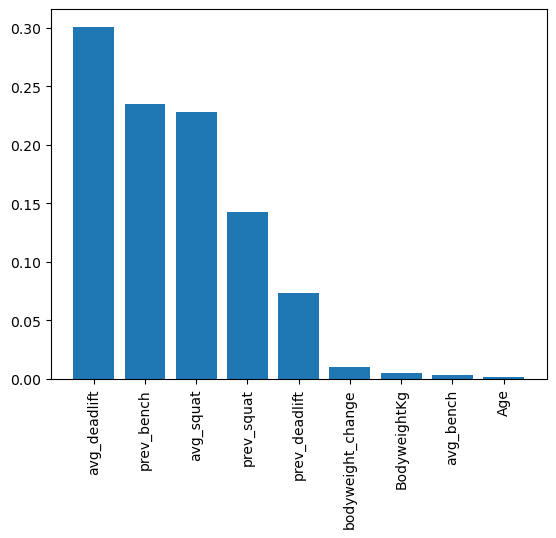

prev_squat: Score: 0.14274
prev_bench: Score: 0.23488
prev_deadlift: Score: 0.07322
avg_squat: Score: 0.22825
avg_bench: Score: 0.00319
avg_deadlift: Score: 0.30089
Age: Score: 0.00160
BodyweightKg: Score: 0.00519
bodyweight_change: Score: 0.01005


In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

split_date = df_with_features['Date'].quantile(0.8)
train_df = df_with_features[df_with_features['Date'] < split_date]
test_df = df_with_features[df_with_features['Date'] >= split_date]

X_train = train_df[feature_columns]
X_test = test_df[feature_columns]
y_train = train_df['TotalKg']
y_test = test_df['TotalKg']

# Scaled
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)  # Fit on training data only
# X_test_scaled = scaler.transform(X_test) 
# model = LinearRegression()
# model.fit(X_train, y_train)
# y_pred = model.predict(X_test)
# importance = model.coef_

model = GradientBoostingRegressor()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
importance = model.feature_importances_

print(f'MAE: {mean_absolute_error(y_test, y_pred)}')
print(f'RMSE: {np.sqrt(mean_squared_error(y_test, y_pred))}')
print(f'MSE: {mean_squared_error(y_test, y_pred)}')
print(f'R2: {r2_score(y_test, y_pred)}\n')

sorted_importance = np.argsort(importance)[::-1]
x = range(len(importance))
labels = np.array(feature_columns)[sorted_importance]
plt.bar(x, importance[sorted_importance], tick_label=labels)
plt.xticks(rotation=90)
plt.show()


for i, v in zip(feature_columns ,importance):
    print(f"{i}: Score: {v:.5f}")

# plt.bar([x for x in range(len(importance))], importance)
# plt.show()



## time based cross validation

In [8]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

# # TIME SERIES CROSS VALIDATIONS
X = df_with_features[feature_columns]
y = df_with_features['TotalKg']
scores = {'mae': [], 'rmse': [], 'r2': []}

tscv = TimeSeriesSplit(n_splits=5)
for index, (train_index, test_index) in enumerate(tscv.split(X)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    gbr = GradientBoostingRegressor()
    gbr.fit(X_train, y_train)
    gbr_y_pred = gbr.predict(X_test)

    mae = mean_absolute_error(y_test, gbr_y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, gbr_y_pred))
    r2 = r2_score(y_test, gbr_y_pred)
    scores['mae'].append(mae)
    scores['rmse'].append(rmse)
    scores['r2'].append(r2)
    print(f'Fold {index}, MAE={mae:.2f}, RMSE={rmse:.2f}, R2={r2:.3f}')

"""GBR
Fold 0, MAE=21.09, RMSE=34.46, R2=0.953
Fold 1, MAE=20.27, RMSE=33.28, R2=0.955
Fold 2, MAE=19.22, RMSE=31.85, R2=0.961
Fold 3, MAE=19.76, RMSE=32.30, R2=0.960
Fold 4, MAE=20.18, RMSE=31.77, R2=0.961"""
"""LR
Fold 0, MAE=21.14, RMSE=35.07, R2=0.951
Fold 1, MAE=20.67, RMSE=34.61, R2=0.951
Fold 2, MAE=19.63, RMSE=33.09, R2=0.958
Fold 3, MAE=20.09, RMSE=33.41, R2=0.957
Fold 4, MAE=20.50, RMSE=32.82, R2=0.958"""
"""RFR
Fold 0, MAE=22.07, RMSE=37.12, R2=0.945
Fold 1, MAE=20.94, RMSE=34.52, R2=0.951
Fold 2, MAE=19.62, RMSE=32.59, R2=0.959
Fold 3, MAE=20.25, RMSE=33.09, R2=0.958
Fold 4, MAE=20.75, RMSE=32.76, R2=0.958"""

Fold 0, MAE=20.13, RMSE=31.85, R2=0.961
Fold 1, MAE=20.11, RMSE=31.60, R2=0.960
Fold 2, MAE=21.99, RMSE=33.77, R2=0.954
Fold 3, MAE=20.69, RMSE=36.32, R2=0.946
Fold 4, MAE=21.72, RMSE=39.63, R2=0.939


'RFR\nFold 0, MAE=22.07, RMSE=37.12, R2=0.945\nFold 1, MAE=20.94, RMSE=34.52, R2=0.951\nFold 2, MAE=19.62, RMSE=32.59, R2=0.959\nFold 3, MAE=20.25, RMSE=33.09, R2=0.958\nFold 4, MAE=20.75, RMSE=32.76, R2=0.958'